# Company Data Analysis

## Part 1: Loading Data

In [1]:
import pandas as pd

path = 'C:/Users/2093/Desktop/Data Center/03. Data/05. TAITRA/CRM/'

# Company profile datasets
tax      = pd.read_csv(path + 'tax_utf-8.csv', header=0, index_col=False,
                       names=['bogus', 'address', 'id', 'com_name', 'capital', 'est_date', 'invoice',
                              'biz1_id', 'biz1', 'biz2_id', 'biz2', 'biz3_id', 'biz3',
                              'biz4_id', 'biz4'],
                       dtype={'bogus': str,
                              'address': str,
                              'id': str,
                              'com_name': str,
                              'capital': int,
                              'est_date': int,
                              'invoice': str,
                              'biz1_id': str,
                              'biz1': str,
                              'biz2_id': str,
                              'biz2': str,
                              'biz3_id': str,
                              'biz3': str,
                              'biz4_id': str,
                              'biz4': str})
tax.set_index('id', inplace=True)
factory  = pd.read_csv(path + 'factory_utf-8.csv', header=0, index_col=False,
                       names=['bogus', 'com_name', 'factory_id', 'permit_id', 'address', 'county',
                              'ceo', 'id', 'entity_type', 'reg_date', 'permi_date', 'status', 'industry',
                              'product'],
                       dtype={'bogus': str,
                              'com_name': str,
                              'factory_id': str,
                              'permit_id': str,
                              'address': str,
                              'county': str,
                              'ceo': str,
                              'id': str,
                              'entity_type': str,
                              'reg_date': float,
                              'premi_date': int,
                              'status': str,
                              'industry': str,
                              'product': str})
factory.set_index('id', inplace=True)
biz_nature = pd.read_csv('C:/Users/2093/Desktop/Data Center/03. Data/06. companies/COMP_TYPE.csv',
                         index_col=False, header=0,
                         names=['biz_nature', 'biz_nature_id', 'id', 'user', 'date', 'bogus'],
                         dtype={'biz_nature': str,
                                'biz_nature_id': int,
                                'id': str,
                                'user': str,
                                'date': str,
                                'bogus': str})
biz_nature.set_index('id', inplace=True)
biz_nature = biz_nature[['biz_nature']]
# Event participation data
event    = pd.read_csv(path + 'crm_group.csv', usecols=range(4), header=0,
                       names=['year', 'event_name', 'source', 'event_id'])
attend   = pd.read_csv(path + 'crm_basic_group.csv', usecols=range(2), header=0,
                       names=['event_id', 'bogus'])

In [2]:
# Fix the invalid date '660700' found during datetime conversion
tax.loc['40084498', 'est_date'] = 660701

In [3]:
def parseDate(x):
    return pd.to_datetime(list(map(str, x + 19110000)), format='%Y%m%d', errors='coerce')

tax['est_date'] = parseDate(tax['est_date'])
factory['reg_date'] = parseDate(factory['reg_date'])
factory['permi_date'] = parseDate(factory['permi_date'])

## Part 2: Event Participation EDA

- Time span of event records:
  2013, 2014, 2015, 2016

- No. of unique companies who have attended at least once over the 4 years:
  128,869

- Most attended events:
+----------------------------+-------------+----------------+
| source                     |   n_company |   fraction (%) |
|----------------------------+-------------+----------------|
| WISC光碟名錄-CRM_FMSISCM   |       90901 |       70.5375  |
| J國內專業展-CRM_FMSPROFM   |       33596 |       26.0699  |
| T研討會-CRM_FMSDISCM       |       12759 |        9.90075 |
| U洽談會-CRM_FMSDISCM       |       12098 |        9.38783 |
| N公會資料-CRM_FMSPUBLICM   |        7483 |        5.80667 |
| OBOFT績優廠商-CRM_FMSBOFTM |        4299 |        3.33595 |
| A國外參展-CRM_FMSEXHIBITM  |        2829 |        2.19525 |
| M會議室資料-CRM_FMSMEETRM  |        1963 |        1.52325 |
+----------------------------+-------------+----------------+


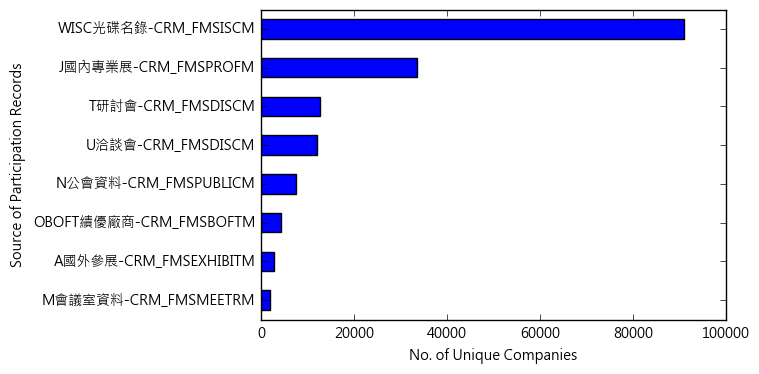

We can see that participation records for directories, trade shows, seminars, and procurement meetings are more likely to be useful later.


In [4]:
from tabulate import tabulate
import matplotlib.pyplot as plt

attend = pd.merge(attend, event, how='left', on='event_id')

print('- Time span of event records:\n  {}\n'.format(
        ', '.join(map(str, sorted(attend['year'].unique())))))
n_attendant = len(attend['bogus'].unique())
print('- No. of unique companies who have attended at least once over the 4 years:\n  {:,}\n'.format(
        n_attendant))
print('- Most attended events:')

event_stats = attend.groupby('source').agg({'bogus': 'nunique'}).rename(columns={'bogus': 'n_company'})
event_stats['fraction (%)'] = event_stats['n_company'] / n_attendant * 100
event_stats = event_stats.sort_values(by='n_company', ascending=False)
print(tabulate(event_stats, headers='keys', tablefmt='psql'))

plt.clf()
event_stats['n_company'].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('No. of Unique Companies')
plt.ylabel('Source of Participation Records')
plt.show()

print('We can see that participation records for directories, trade shows, seminars, and procurement meetings are more likely',
      'to be useful later.')

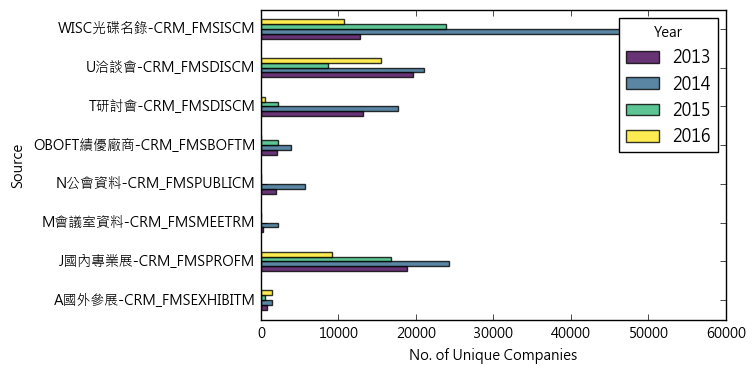

Apart from procurement meeting, all categories have shown a downward trend since 2014.


In [5]:
# Yearly trend
plt.clf()
year_event = attend.groupby(['year', 'source']).agg({'event_id': 'count'})
year_event.reset_index(inplace=True)
pd.pivot_table(year_event, index='source', columns='year', values='event_id').plot(
    kind='barh', colormap='viridis', alpha=0.8)
plt.xlabel('No. of Unique Companies')
plt.ylabel('Source')
plt.legend(title='Year')
plt.show()

print('Apart from procurement meeting, all categories have shown a downward trend since 2014.')

In [6]:
# Compute no. of events each company participates in for 2013~2016
com_event = attend.groupby(['bogus', 'year']).agg({'event_id': 'count'})
com_event.reset_index(inplace=True)
com_event = pd.pivot_table(com_event, index='bogus', columns='year', values='event_id', fill_value=0)
com_event.columns = ['n_event' + str(y) for y in range(13, 17)]
com_event['n_event'] = com_event.sum(axis=1)
com_event.head()

,n_event13,n_event14,n_event15,n_event16,n_event
bogus,,,,,
0000C9064A,0,9,1,3,13
00022B661F,0,1,0,0,1
00027C3C23,2,0,1,0,3
00033F38F0,0,1,0,0,1
0003C338A1,0,1,0,0,1


In [7]:
# Compute no. of events each company participates in by source
com_source = attend.groupby(['bogus', 'source']).agg({'event_id': 'count'})
com_source.reset_index(inplace=True)
com_source = pd.pivot_table(com_source, index='bogus', columns='source', values='event_id', fill_value=0)
com_source.head()

source,A國外參展-CRM_FMSEXHIBITM,J國內專業展-CRM_FMSPROFM,M會議室資料-CRM_FMSMEETRM,N公會資料-CRM_FMSPUBLICM,OBOFT績優廠商-CRM_FMSBOFTM,T研討會-CRM_FMSDISCM,U洽談會-CRM_FMSDISCM,WISC光碟名錄-CRM_FMSISCM
bogus,,,,,,,,
0000C9064A,1,1,0,0,0,7,4,0
00022B661F,0,0,0,0,0,0,0,1
00027C3C23,0,0,0,0,0,2,0,1
00033F38F0,0,0,0,0,0,0,0,1
0003C338A1,0,0,0,0,0,0,0,1


## Part 3: Association Rule Mining

In [8]:
def support(df, *col_index):
    nrows = len(df)
    for i in col_index:
        df = df[df.iloc[:, i] != 0]
    return len(df) / nrows

def confidence(df, x_index, y_index):
    return support(df, x_index, y_index) / support(df, x_index)

def lift(df, x_index, y_index):
    return confidence(df, x_index, y_index) / support(df, y_index)

In [9]:
import itertools

n_category = com_source.shape[1]
combi = list(itertools.permutations(range(n_category), 2))
rules = pd.DataFrame({
    'lhs': com_source.columns[list(list(zip(*combi))[0])],
    'rhs': com_source.columns[list(list(zip(*combi))[1])],
    'support': list(map(lambda x: support(com_source, *x), combi)),
    'confidence': list(map(lambda x: confidence(com_source, *x), combi)),
    'lift': list(map(lambda x: lift(com_source, *x), combi))
    })[['lhs', 'rhs', 'support', 'confidence', 'lift']]
rules.head()

,lhs,rhs,support,confidence,lift
0,A國外參展-CRM_FMSEXHIBITM,J國內專業展-CRM_FMSPROFM,0.012478,0.568399,2.180289
1,A國外參展-CRM_FMSEXHIBITM,M會議室資料-CRM_FMSMEETRM,0.001707,0.077766,5.105260
2,A國外參展-CRM_FMSEXHIBITM,N公會資料-CRM_FMSPUBLICM,0.002406,0.109579,1.887128
3,A國外參展-CRM_FMSEXHIBITM,OBOFT績優廠商-CRM_FMSBOFTM,0.001839,0.083775,2.511287
4,A國外參展-CRM_FMSEXHIBITM,T研討會-CRM_FMSDISCM,0.009839,0.448215,4.527080


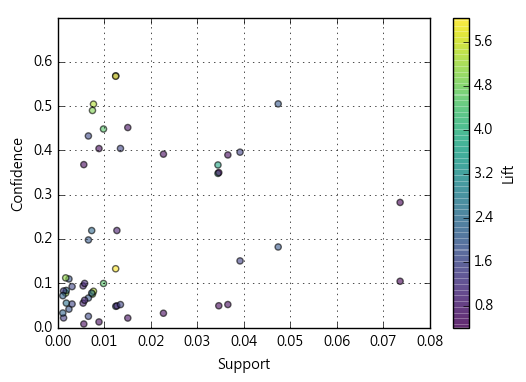

Some of the most interesting rules:
+----+---------------------------+--------------------------+------------+--------------+---------+
|    | lhs                       | rhs                      |    support |   confidence |    lift |
|----+---------------------------+--------------------------+------------+--------------+---------|
|  0 | A國外參展-CRM_FMSEXHIBITM | J國內專業展-CRM_FMSPROFM | 0.0124778  |     0.568399 | 2.18029 |
|  1 | A國外參展-CRM_FMSEXHIBITM | U洽談會-CRM_FMSDISCM     | 0.0124545  |     0.567338 | 6.04334 |
|  2 | U洽談會-CRM_FMSDISCM      | J國內專業展-CRM_FMSPROFM | 0.0474047  |     0.504959 | 1.93695 |
|  3 | M會議室資料-CRM_FMSMEETRM | U洽談會-CRM_FMSDISCM     | 0.00768222 |     0.50433  | 5.37217 |
+----+---------------------------+--------------------------+------------+--------------+---------+
有參加國外參展團的廠商，參加國內展的機率達0.57，參加洽談會的機率達0.57。
有參加洽淡會的廠商，參加國內展的機率也有0.50。


In [10]:
plt.clf()
fig, ax = plt.subplots()
rules[['support', 'confidence', 'lift']].plot(ax=ax,
    x='support', y='confidence', kind='scatter', c='lift', colormap='viridis', alpha=0.6)
ax.set_xlabel('Support')
ax.set_ylabel('Confidence')
fig.get_axes()[1].set_ylabel('Lift')
plt.axis([0, 0.08, 0., 0.7])
plt.grid(True)
plt.show()

interesting_rules = rules.sort_values('confidence', ascending=False).head(4).reset_index()
print('Some of the most interesting rules:')
print(tabulate(interesting_rules.iloc[:, 1:], headers='keys', tablefmt='psql'))
print('有參加國外參展團的廠商，參加國內展的機率達{:.2f}，參加洽談會的機率達{:.2f}。\n'.format(
    interesting_rules.ix[0, 'confidence'],
    interesting_rules.ix[1, 'confidence']) +
      '有參加洽淡會的廠商，參加國內展的機率也有{:.2f}。'.format(interesting_rules.ix[2, 'confidence']))

## Part 4: Factories

#### It may seem that every factory can be uniquely identified by a BAN. However, this is actually not the case:

In [11]:
len(factory.index) == len(factory.index.unique())

False

In [12]:
factory_count = factory.groupby(level='id').agg({'bogus': 'count'}).rename(columns={'bogus': 'n_factory'})
print('Distribution of no. of factories owned by company:\n')
print(pd.value_counts(factory_count['n_factory']).sort_index())

Distribution of no. of factories owned by company:

1     73697
2      5627
3       752
4       210
5        72
6        37
7        22
8         7
9         7
10        4
11        6
12        2
13        2
17        1
18        1
20        1
27        1
77        1
Name: n_factory, dtype: int64


In [13]:
print('Some of the companies that own the most factories:')
# Indexing from 1 to ignore companies without valid id ("00000000")
pd.merge(factory_count.sort_values('n_factory', ascending=False).head(11).iloc[1:, :], tax,
         how='left', left_index=True, right_index=True)[['com_name', 'n_factory']].rename(
    columns={'com_name': 'Company Name', 'n_factory': 'No. of Factories Owned'})

Some of the companies that own the most factories:


,Company Name,No. of Factories Owned
id,,
76027628,日月光半導體製造股份有限公司,27
24060203,國產建材實業股份有限公司,20
22099131,台灣積體電路製造股份有限公司,18
11072509,三福氣體股份有限公司,17
23535435,欣興電子股份有限公司,13
22798584,恒耀工業股份有限公司,13
12800225,群創光電股份有限公司,12
73251209,統一企業股份有限公司,12
23503047,上銀科技股份有限公司,11


In [14]:
# When a company owns multiple factories, we will keep only the one with the earliest permi_date
factory.reset_index(inplace=True)
factory['est_ord'] = factory.groupby('id')['permi_date'].rank()
factory.set_index('id', inplace=True)
factory = factory[factory['est_ord'] == 1]
len(factory.index) == len(factory.index.unique())

True

In [15]:
print('The factory dataset contains {:,} companies that are not listed in the tax dataset.\n'.format(
        len(list(set(factory.index.unique()) - set(tax.index.unique())))) +
      'These companies will be missing in the following analysis.')

The factory dataset contains 1,217 companies that are not listed in the tax dataset.
These companies will be missing in the following analysis.


## Part 5: Final Preprocessing

In [16]:
com_source.columns = ['n_fshow', 'n_dshow', 'n_room', 'n_membership', 'n_awarded', 'n_seminar',
                      'n_meeting', 'n_directory']
# Merge event statistics tables
com = com_event.merge(com_source, how='inner', left_index=True, right_index=True)
# Merge all tables
df = tax.merge(factory, how='left', left_index=True, right_index=True).merge(
    factory_count, how='left', left_index=True, right_index=True).merge(
    biz_nature, how='left', left_index=True, right_index=True).merge(
    com, how='left', left_on='bogus_x', right_index=True)

In [17]:
import re

# Drop less useful columns
df.drop(['bogus_x', 'invoice', 'bogus_y', 'com_name_y', 'factory_id', 'permit_id', 'address_y',
         'est_ord'], axis=1, inplace=True)
# Rename suffixed columns
df.columns = list(map(lambda s: re.sub('_x$', '', s), df.columns))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1552719 entries, 00000206 to 99995009
Data columns (total 35 columns):
address         1552719 non-null object
com_name        1552718 non-null object
capital         1552719 non-null int32
est_date        1552718 non-null datetime64[ns]
biz1_id         1552719 non-null object
biz1            1545094 non-null object
biz2_id         738133 non-null object
biz2            737140 non-null object
biz3_id         360753 non-null object
biz3            360209 non-null object
biz4_id         183515 non-null object
biz4            183204 non-null object
county          137399 non-null object
ceo             137399 non-null object
entity_type     137387 non-null object
reg_date        75093 non-null datetime64[ns]
permi_date      137399 non-null datetime64[ns]
status          137399 non-null object
industry        137387 non-null object
product         137327 non-null object
n_factory       138016 non-null float64
biz_nature      229370 non-null obje